In [8]:
import random
import pandas as pd
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dropout, Dense
import keras as k
import keras.backend as K
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [76]:
# Read the Data
#df = pd.read_csv('../../data/original.csv',  index_col=0)
df = pd.read_csv('../../data/MCAR/mcar10/mcar_10.csv',  index_col=0)
y = np.array(df['group'])
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

#scale the data
X = df.drop(['group'], axis = 1)
#scaler = StandardScaler()
#X = scaler.fit_transform(X)

X = np.array(X)  
n_dims = X.shape[1]

latent_dim = 2

In [17]:
#Define Variational Auto Encoder
encoder_input = k.Input(shape=(n_dims,))
x = k.layers.Dense(128, activation='relu')(encoder_input)
x = k.layers.Dropout(0.2)(x)
x = k.layers.Dense(32, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
z_mean = k.layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = k.layers.Dense(latent_dim, name='z_log_var')(x)
z = k.layers.Lambda(sampling, name='z')([z_mean, z_log_var])

# Define decoder layers
decoder_input = k.layers.Input(shape=(latent_dim,))
x = k.layers.Dense(32, activation='relu')(decoder_input)
x = k.layers.Dense(128, activation='relu')(x)
x = k.layers.Dense(n_dims, activation='sigmoid')(x)
decoder_output = k.layers.Reshape((n_dims,))(x)

decoder = k.models.Model(decoder_input, decoder_output, name='decoder')

# Define the VAE model
encoder_output = [z_mean, z_log_var, z]
encoder = k.Model(encoder_input, encoder_output, name='encoder')
output = decoder(encoder_output[2])
vae = k.Model(encoder_input, output, name='vae')

def vae_loss(inputs, outputs):
    reconstruction_loss = mse(inputs, outputs)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return reconstruction_loss + kl_loss


vae.compile(optimizer='adam', loss = vae_loss)
vae.fit(x=X, y=X, epochs=40, batch_size=16, verbose=1)

In [116]:
import tensorflow as tf
from keras.layers import Input, Dense, Flatten, Reshape, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.backend import binary_crossentropy
from keras.layers import concatenate
from keras.losses import mean_squared_error
encoder_input = Input(shape=(n_dims,))
encoder_seq = Sequential()
encoder_seq.add(Dense(hidden_dim, activation='relu', input_shape= (n_dims,)))
encoder_seq.add(Dense(hidden_dim, activation='relu'))

encoder_mu = Dense(latent_dim, activation='linear')(encoder_seq(encoder_input))
encoder_log_sigma = Dense(latent_dim, activation='linear')(encoder_seq(encoder_input))

def _sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2) * eps

encoder_output = Lambda(_sample_z)([encoder_mu, encoder_log_sigma])

decoder_input = Input(shape=[latent_dim])

decoder_seq = Sequential()
decoder_seq.add(Dense(hidden_dim, activation='relu', input_shape=[latent_dim]))
decoder_seq.add(Dense(hidden_dim, activation='relu'))
decoder_seq.add(Dense(n_dims, activation='linear'))

encoder_model = Model(inputs=encoder_input, outputs=encoder_output)
decoder_model = Model(inputs=decoder_input, outputs=decoder_seq(decoder_input))
full_model = Model(inputs=encoder_input, 
                   outputs=concatenate([encoder_mu, encoder_log_sigma, decoder_seq(encoder_output)]))

adam_opt = Adam(lr=0.01)

def _vae_loss(y_true, model_output):
   
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    encoder_mu = model_output[:, 0:latent_dim]
    encoder_log_sigma = model_output[:, latent_dim:latent_dim*2]
    y_pred = model_output[:, latent_dim*2:]
    
    # E[log P(X|z)] - this is because we model our P(X_i|z) as a normal distribution
    #recon =  K.sum(K.binary_crossentropy(y_truey_true), axis=1)

    recon = mean_squared_error(y_true, y_pred)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian

    kl = 0.5 * K.sum(K.exp(encoder_log_sigma) + K.square(encoder_mu) - 1. - encoder_log_sigma, axis=1)

    return recon + kl

opt = Adam(lr=0.01)

full_model.compile(optimizer=opt, loss=_vae_loss)

In [117]:
full_model.fit(x=X, y=X, epochs=200, batch_size=16)

Epoch 1/200
63/63 [==============================] - 0s 2ms/step - loss: 561.8112
Epoch 2/200
63/63 [==============================] - 0s 1ms/step - loss: 1362197504.0000
Epoch 3/200
63/63 [==============================] - 0s 1ms/step - loss: 5820.7490
Epoch 4/200
63/63 [==============================] - 0s 1ms/step - loss: 2841.6187
Epoch 5/200
63/63 [==============================] - 0s 1ms/step - loss: 2830.0195
Epoch 6/200
63/63 [==============================] - 0s 1ms/step - loss: 2829.8428
Epoch 7/200
63/63 [==============================] - 0s 1ms/step - loss: 2829.8315
Epoch 8/200
63/63 [==============================] - 0s 1ms/step - loss: 2829.8289
Epoch 9/200
63/63 [==============================] - 0s 1ms/step - loss: 2829.8186
Epoch 10/200
63/63 [==============================] - 0s 1ms/step - loss: 2829.8154
Epoch 11/200
63/63 [==============================] - 0s 2ms/step - loss: 2829.8047
Epoch 12/200
63/63 [==============================] - 0s 1ms/step - loss: 2829.7

63/63 [==============================] - 0s 2ms/step - loss: 2752.3679
Epoch 195/200
63/63 [==============================] - 0s 2ms/step - loss: 2749.8984
Epoch 196/200
63/63 [==============================] - 0s 2ms/step - loss: 2747.3479
Epoch 197/200
63/63 [==============================] - 0s 2ms/step - loss: 2744.7207
Epoch 198/200
63/63 [==============================] - 0s 2ms/step - loss: 2742.0046
Epoch 199/200
63/63 [==============================] - 0s 1ms/step - loss: 2739.1992
Epoch 200/200
63/63 [==============================] - 0s 1ms/step - loss: 2736.3196


In [123]:
decoded = full_model.predict(X)
df2 = pd.DataFrame(decoded)

32/32 [==============================] - 0s 1ms/step


In [124]:
df2

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,1000,1001,1002
0,0.209920,-0.191290,-3023.990479,-2387.678711,4.771193,4.283093,7.575696,6.577755,4.712870,0.162074,...,1.267912,0.187534,3.256027,4.731259,2.288139,3.347955,3.732381,4.415110,2.526269,5.732407
1,0.226003,0.220579,-3053.531006,-2411.216309,4.770478,4.282456,7.579522,6.589469,4.709487,0.165124,...,1.265427,0.190406,3.252181,4.734556,2.288889,3.348933,3.731809,4.416859,2.525830,5.735402
2,-0.030451,0.041746,-3024.642578,-2387.865234,4.773438,4.285091,7.563685,6.541003,4.723484,0.152506,...,1.275711,0.178524,3.268095,4.720917,2.285787,3.344887,3.734176,4.409623,2.527647,5.723004
3,-0.116386,-0.005885,-3015.500732,-2381.737061,4.776764,4.287994,7.547394,6.490304,4.738409,0.139841,...,1.286426,0.166652,3.284780,4.706784,2.282196,3.340564,3.736717,4.402159,2.529271,5.710258
4,0.112636,-0.147029,-2947.943115,-2327.372803,4.772985,4.284688,7.566106,6.548404,4.721346,0.154432,...,1.274140,0.180338,3.265664,4.723000,2.286261,3.345505,3.733814,4.410728,2.527370,5.724897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.096993,0.189817,-3121.239258,-2465.840088,4.772583,4.284331,7.568258,6.554996,4.719442,0.156149,...,1.272742,0.181954,3.263500,4.724855,2.286683,3.346055,3.733492,4.411711,2.527122,5.726583
996,0.187721,-0.011920,-3113.145752,-2458.492676,4.770478,4.282456,7.579522,6.589469,4.709487,0.165124,...,1.265427,0.190406,3.252181,4.734556,2.288889,3.348933,3.731809,4.416859,2.525830,5.735402
997,0.236328,0.302938,-3035.670654,-2397.956055,4.770478,4.282456,7.579522,6.589469,4.709487,0.165124,...,1.265427,0.190406,3.252181,4.734556,2.288889,3.348933,3.731809,4.416859,2.525830,5.735402
998,0.188697,0.030748,-2963.992676,-2341.177979,4.770478,4.282456,7.579522,6.589469,4.709487,0.165124,...,1.265427,0.190406,3.252181,4.734556,2.288889,3.348933,3.731809,4.416859,2.525830,5.735402


In [122]:
df

,Gene1,Gene2,Gene3,Gene4,Gene5,Gene6,Gene7,Gene8,Gene9,Gene10,...,Gene992,Gene993,Gene994,Gene995,Gene996,Gene997,Gene998,Gene999,Gene1000,group
Cell1,4.411958,4.259444,NaN,7.360808,5.221280,0.0,3.545698,3.895414,2.664234,4.675757,...,0.00000,3.995388,4.176682,2.398111,4.482566,4.846107,4.411958,2.888828,6.693584,Group2
Cell2,4.866728,5.131195,8.511533,6.638323,5.548023,0.0,NaN,5.354611,2.176975,6.438011,...,0.00000,3.798482,5.750356,2.780325,3.531835,5.224752,5.354611,2.509964,5.354611,Group4
Cell3,5.395390,5.095406,8.600619,6.761085,4.955451,0.0,3.154103,NaN,2.872133,4.716216,...,NaN,NaN,6.264117,0.000000,3.928210,4.531390,4.955451,1.367576,6.674454,Group3
Cell4,NaN,4.483988,8.039327,7.265012,5.098207,0.0,2.523711,4.843571,2.709811,5.098207,...,0.00000,4.073418,4.432017,3.279385,NaN,NaN,4.203110,2.874625,6.608741,Group2
Cell5,5.635553,NaN,8.333183,7.380456,NaN,0.0,1.559992,3.665749,0.000000,6.029039,...,0.00000,2.775170,5.691020,0.000000,4.487599,3.871810,5.007929,3.665749,6.438542,Group4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell996,5.397102,4.691476,NaN,6.432691,5.449296,NaN,3.746257,4.046522,1.734938,4.691476,...,0.00000,3.131289,5.595422,NaN,NaN,4.294931,4.176066,3.471295,5.790126,Group1
Cell997,5.230264,5.230264,8.510772,7.160785,5.433668,0.0,4.298275,4.796713,2.086711,5.563187,...,0.00000,4.237473,5.029714,NaN,4.568914,4.568914,4.993401,NaN,6.162680,Group4
Cell998,5.503549,4.757081,8.584588,7.087758,4.704684,0.0,2.762754,4.038414,NaN,6.323509,...,0.00000,3.123646,5.440863,0.000000,2.280344,NaN,4.757081,2.541620,6.662581,Group4
Cell999,5.519776,4.978105,8.068679,7.193865,NaN,0.0,2.674807,2.198606,2.674807,5.824017,...,1.48294,NaN,5.133744,1.482940,2.198606,4.374828,4.707773,2.674807,5.824017,Group3


32/32 [==============================] - 0s 802us/step


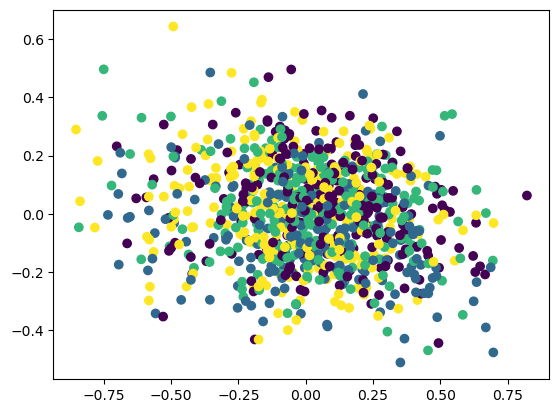

In [120]:
embedding = encoder_model.predict(X)


plt.scatter(embedding[:, 0], embedding[:, 1], c=y)
plt.show()

In [20]:
import tensorflow as tf
from keras.layers import Input, Dense, Flatten, Reshape, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.backend import binary_crossentropy
from keras.layers import concatenate
from keras.losses import mean_squared_error


encoder_input = Input(shape=(n_dims*2,))
encoder_seq = Sequential()
encoder_seq.add(Dense(64, activation='linear', input_shape= (n_dims*2,)))
encoder_seq.add(Dense(32, activation='linear'))

encoder_mu = Dense(latent_dim, activation='linear')(encoder_seq(encoder_input))
encoder_log_sigma = Dense(latent_dim, activation='linear')(encoder_seq(encoder_input))

def _sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2) * eps

encoder_output = k.layers.Lambda(_sample_z)([encoder_mu, encoder_log_sigma])

decoder_input = Input(shape=[latent_dim])

decoder_seq = Sequential()
decoder_seq.add(Dense(32, activation='linear', input_shape=[latent_dim]))
decoder_seq.add(Dense(64, activation='linear'))
decoder_seq.add(Dense(n_dims, activation='linear'))

encoder_model = Model(inputs=encoder_input, outputs=encoder_output)
decoder_model = Model(inputs=decoder_input, outputs=decoder_seq(decoder_input))
full_model = Model(inputs=encoder_input, 
                   outputs=concatenate([encoder_mu, encoder_log_sigma, decoder_seq(encoder_output)]))

adam_opt = Adam(lr=0.01)

def _vae_loss(input_and_mask, model_output):
    
    encoder_mu = model_output[:, 0:latent_dim]
    encoder_log_sigma = model_output[:, latent_dim:latent_dim*2]
    y_pred = model_output[:, latent_dim*2:]

    X_values = input_and_mask[:, :n_dims]
    missing_mask = input_and_mask[:, n_dims:]
    observed_mask = 1 - missing_mask
    y_true = X_values * observed_mask
    pred_observed = y_pred * observed_mask
    


    # E[log P(X|z)] - this is because we model our P(X_i|z) as a normal distribution
    #recon =  K.sum(K.binary_crossentropy(y_truey_true), axis=1)

    recon = mean_squared_error(y_true, y_pred)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian

    kl = 0.5 * K.sum(K.exp(encoder_log_sigma) + K.square(encoder_mu) - 1. - encoder_log_sigma, axis=1)

    return K.mean(recon + kl)

opt = Adam(lr=0.01)

full_model.compile(optimizer=opt, loss=_vae_loss)



In [21]:
mask = np.array(bool_to_binary(create_missing_mask(X)))
X_no_na = replace_nan(X, replacement = 1)
input_with_mask = np.hstack([X_no_na, mask])

full_model.fit(x=input_with_mask, y=input_with_mask, epochs=20, batch_size=16, verbose=1)

Epoch 1/20
63/63 [==============================] - 0s 2ms/step - loss: 140731105280.0000
Epoch 2/20
63/63 [==============================] - 0s 2ms/step - loss: 1445.8475
Epoch 3/20
63/63 [==============================] - 0s 2ms/step - loss: 1437.1202
Epoch 4/20
63/63 [==============================] - 0s 2ms/step - loss: 1656.6562
Epoch 5/20
63/63 [==============================] - 0s 2ms/step - loss: 2007.3267
Epoch 6/20
63/63 [==============================] - 0s 2ms/step - loss: 1942.5072
Epoch 7/20
63/63 [==============================] - 0s 2ms/step - loss: 1866.4794
Epoch 8/20
63/63 [==============================] - 0s 2ms/step - loss: 1783.7866
Epoch 9/20
63/63 [==============================] - 0s 2ms/step - loss: 1692.9034
Epoch 10/20
63/63 [==============================] - 0s 2ms/step - loss: 1595.7750
Epoch 11/20
63/63 [==============================] - 0s 2ms/step - loss: 1491.6442
Epoch 12/20
63/63 [==============================] - 0s 2ms/step - loss: 1380.4769
Epoch

In [78]:
def masked_mae(X_true, X_pred, mask):
    masked_diff = X_true[mask] - X_pred[mask]
    return np.mean(np.abs(masked_diff))


def fill(self, missing_mask):
  self.data[missing_mask] = -1


def create_missing_mask(X):
  if X.dtype != "f" and X.dtype != "d":
      X = X.astype(float)
  return np.isnan(X.data)


def bool_to_binary(matrix):
  """
  Converts a boolean matrix to a binary matrix

  :param matrix: a boolean matrix
  :return: a binary matrix
  """
  binary_matrix = []
  for row in matrix:
      binary_row = []
      for value in row:
          binary_row.append(1 if value else 0)
      binary_matrix.append(binary_row)
  return binary_matrix


def replace_nan(data, replacement):
  """
  Replace NaN values in a given array with a specific number.

  Args:
  data (array): The data to be processed.
  replacement (float or int): The number to replace NaN values with.

  Returns:
  The processed data with NaN values replaced by the specified number.
  """

  if not isinstance(data, np.ndarray):
      raise ValueError("Unsupported data type. Function supports numpy arrays only.")

  data[np.isnan(data)] = replacement

  return data



In [97]:
mask = np.array(bool_to_binary(create_missing_mask(X)))
X_no_na = replace_nan(X, replacement = 1)
input_with_mask = np.hstack([X_no_na, mask])

full_model.fit(x=input_with_mask, y=input_with_mask, epochs=2, batch_size=16, verbose=1)

Epoch 1/2
Tensor("vae_loss/Shape:0", shape=(2,), dtype=int32)
Tensor("vae_loss/Shape:0", shape=(2,), dtype=int32)
63/63 [==============================] - 1s 2ms/step - loss: 3387675901952.0000
Epoch 2/2
63/63 [==============================] - 0s 2ms/step - loss: 168.4657


In [87]:
embedding = encoder_model.predict(input_with_mask)



32/32 [==============================] - 0s 764us/step


In [89]:
input_with_mask

array([[4.41195763, 4.25944405, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [4.86672759, 5.13119538, 8.51153343, ..., 0.        , 0.        ,
        0.        ],
       [5.3953902 , 5.09540605, 8.60061913, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [5.50354872, 4.75708098, 8.58458809, ..., 0.        , 0.        ,
        0.        ],
       [5.51977628, 4.97810536, 8.06867908, ..., 0.        , 0.        ,
        0.        ],
       [5.22955271, 4.35592154, 8.0035662 , ..., 0.        , 0.        ,
        0.        ]])

In [88]:
embedding

array([[-0.20459144,  1.2673396 ],
       [-1.7312397 ,  0.32091355],
       [ 0.15193692,  0.4918424 ],
       ...,
       [-0.7204473 , -1.4340779 ],
       [ 1.9589283 , -1.9428178 ],
       [-0.36536717,  0.15155244]], dtype=float32)